In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [1]:
file_path = 'D:\\Projects\\Mini_Projects\\Mental_Health_Survey\\Research_Data\\train.csv'

In [4]:
data = pd.read_csv(file_path)

In [5]:
data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [6]:
data.shape

(140700, 20)

In [7]:
data.drop(['id','Name'], axis = 1, inplace = True)

In [8]:
data.columns

Index(['Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Gender                                 140700 non-null  object 
 1   Age                                    140700 non-null  float64
 2   City                                   140700 non-null  object 
 3   Working Professional or Student        140700 non-null  object 
 4   Profession                             104070 non-null  object 
 5   Academic Pressure                      27897 non-null   float64
 6   Work Pressure                          112782 non-null  float64
 7   CGPA                                   27898 non-null   float64
 8   Study Satisfaction                     27897 non-null   float64
 9   Job Satisfaction                       112790 non-null  float64
 10  Sleep Duration                         140700 non-null  

In [10]:
# target value 

data['Depression'].value_counts()

Depression
0    115133
1     25567
Name: count, dtype: int64

In [11]:
depressed_gender = data[data['Depression'] == 1].groupby('Gender')['Depression'].count().sort_values(ascending = False).reset_index()
non_depressed_gender = data[data['Depression'] == 0].groupby('Gender')['Depression'].count().sort_values(ascending = False).reset_index()

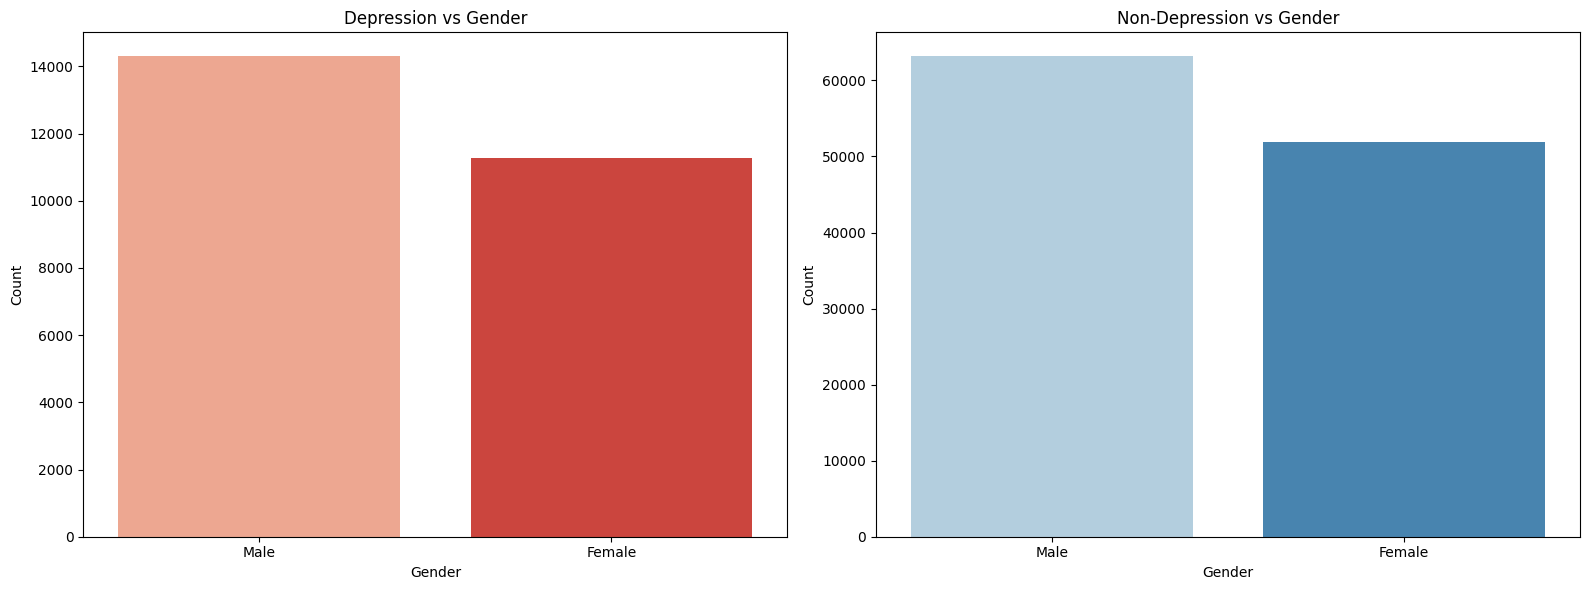

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=depressed_gender, x='Gender', y='Depression', ax=axes[0], palette='Reds')
axes[0].set_title("Depression vs Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Count")

sns.barplot(data=non_depressed_gender, x='Gender', y='Depression', ax=axes[1], palette='Blues')
axes[1].set_title("Non-Depression vs Gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [13]:
depressed_age = data[data['Depression'] == 1].groupby('Age')['Depression'].count().sort_values(ascending = False).reset_index().head(10)
non_depressed_age = data[data['Depression'] == 0].groupby('Age')['Depression'].count().sort_values(ascending = False).reset_index().head(10)

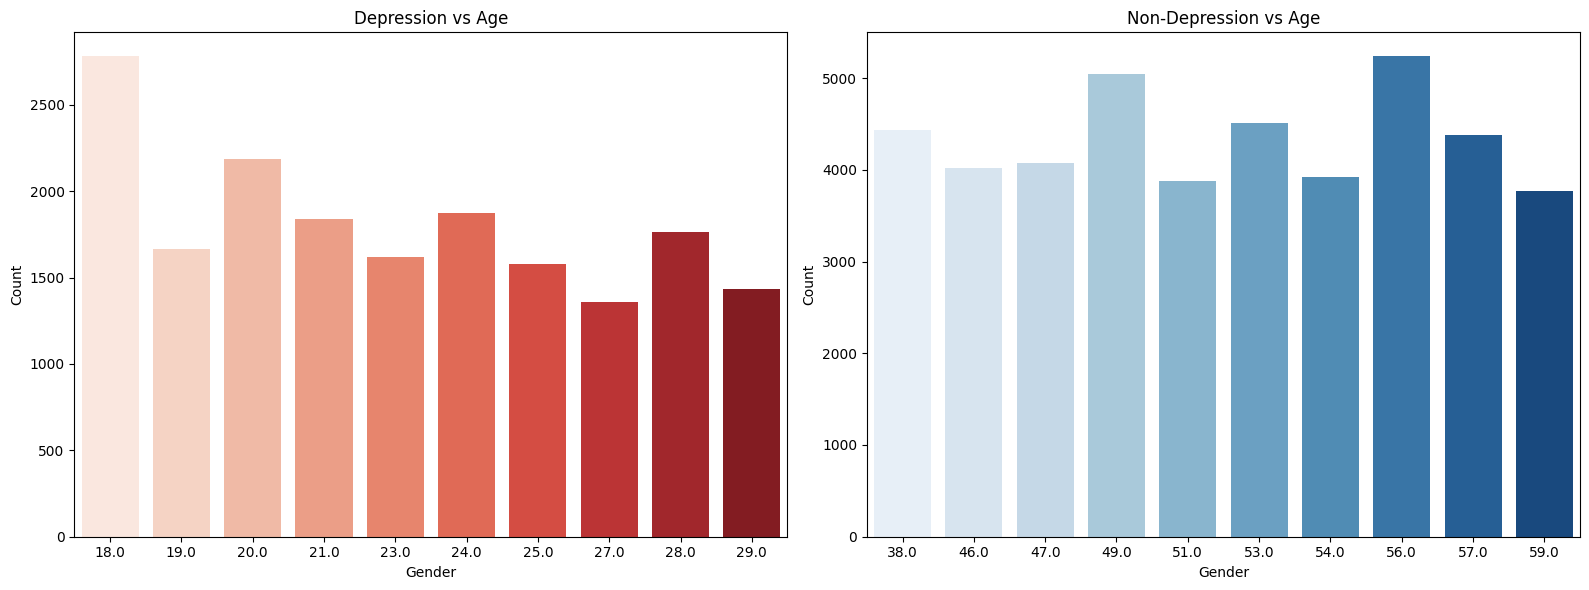

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=depressed_age, x='Age', y='Depression', ax=axes[0], palette='Reds')
axes[0].set_title("Depression vs Age")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Count")

sns.barplot(data=non_depressed_age, x='Age', y='Depression', ax=axes[1], palette='Blues')
axes[1].set_title("Non-Depression vs Age")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [15]:
depressed_city = data[data['Depression'] == 1].groupby('City')['Depression'].count().sort_values(ascending = False).reset_index().head(10)
non_depressed_city = data[data['Depression'] == 0].groupby('City')['Depression'].count().sort_values(ascending = False).reset_index().head(10)

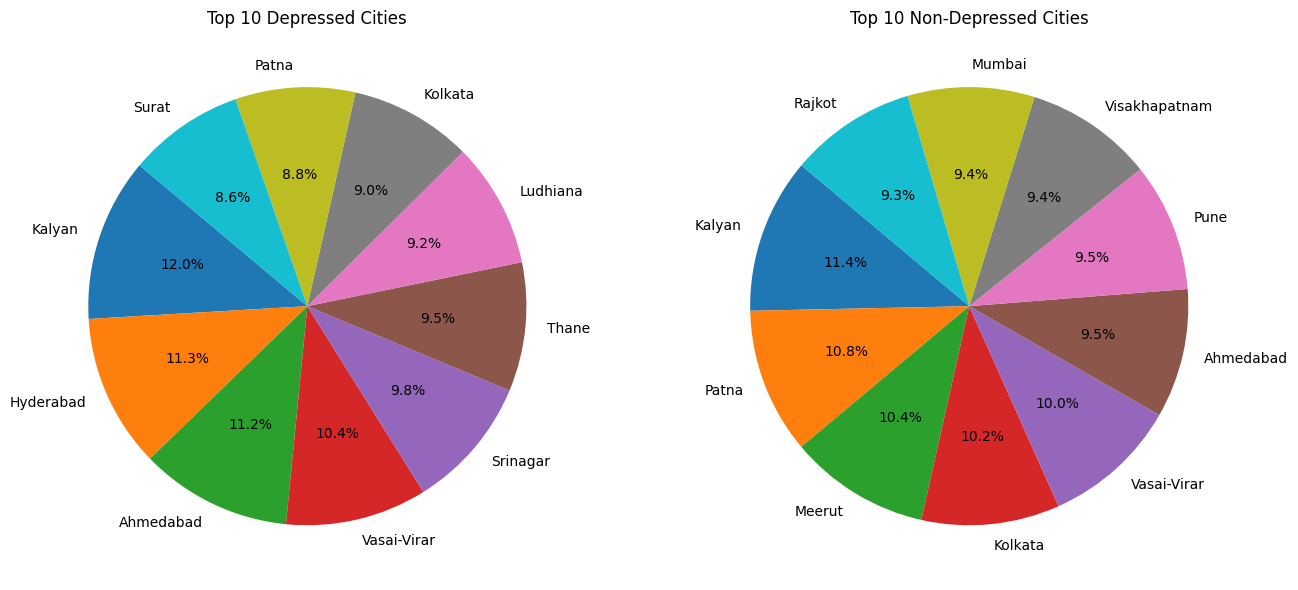

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(
    depressed_city['Depression'],  
    labels=depressed_city['City'],
    autopct='%1.1f%%',  
    startangle=140
)
axes[0].set_title("Top 10 Depressed Cities")

axes[1].pie(
    non_depressed_city['Depression'],  
    labels=non_depressed_city['City'],
    autopct='%1.1f%%',  
    startangle=140  
)
axes[1].set_title("Top 10 Non-Depressed Cities")

plt.tight_layout()
plt.show()

In [17]:
depressed_job = data[data['Depression'] == 1].groupby('Profession')['Depression'].count().sort_values(ascending = False).reset_index().head(10)
non_depressed_job = data[data['Depression'] == 0].groupby('Profession')['Depression'].count().sort_values(ascending = False).reset_index().head(10)

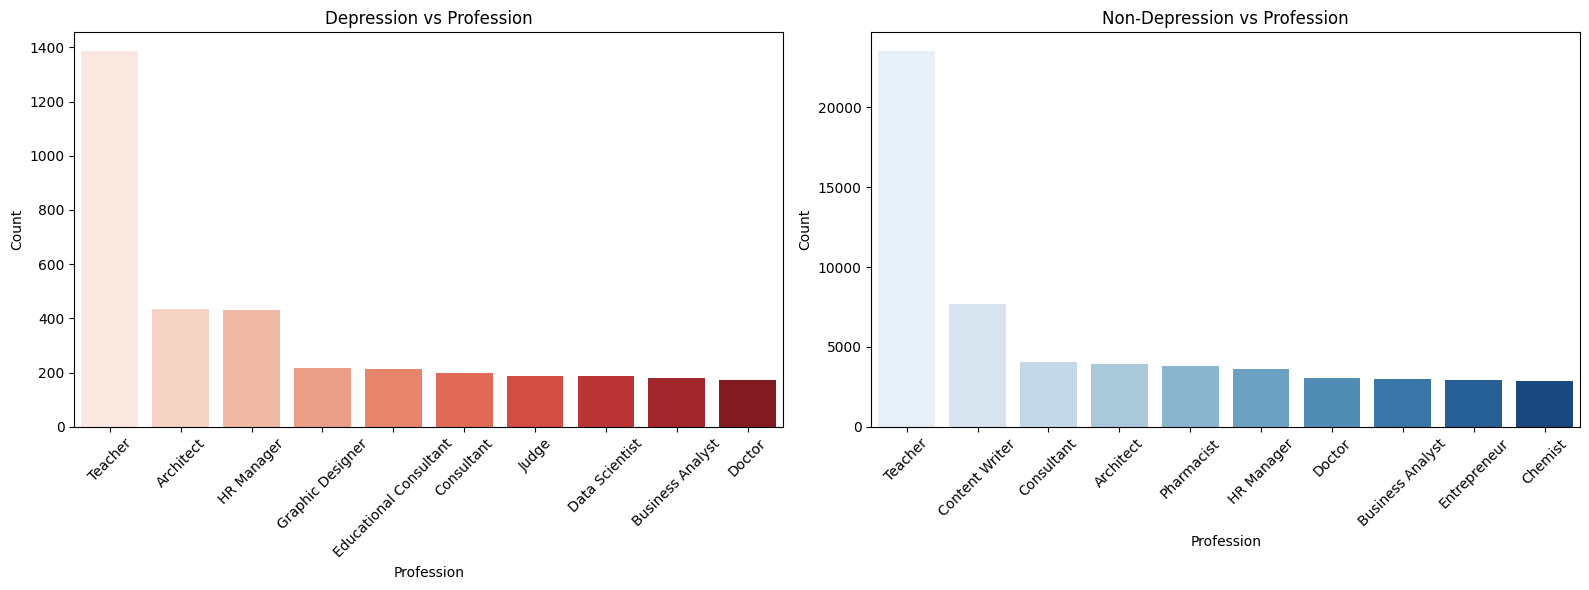

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=depressed_job, x='Profession', y='Depression', ax=axes[0], palette='Reds')
axes[0].set_title("Depression vs Profession")
axes[0].set_xlabel("Profession")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=non_depressed_job, x='Profession', y='Depression', ax=axes[1], palette='Blues')
axes[1].set_title("Non-Depression vs Profession")
axes[1].set_xlabel("Profession")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [19]:
def categorize_sleep(duration):
    duration = duration.lower()
    
    if any(x in duration for x in ["less than 5", "1-2", "2-3", "3-4", "4-5", "than 5"]):
        return "Less than 5 hours"
    elif any(x in duration for x in ["5-6", "4-6", "3-6", "6-7", "1-6"]):
        return "5-6 hours"
    elif any(x in duration for x in ["7-8", "6-8", "8 hours"]):
        return "6-8 hours"
    elif any(x in duration for x in ["more than 8", "8-9", "9-11", "10-11"]):
        return "More than 8 hours"
    else:
        return "Invalid"
    
data['Sleep Duration'] = data['Sleep Duration'].apply(categorize_sleep)
data.drop(data[data['Sleep Duration']=='Invalid'].index, inplace = True)

In [20]:
depressed_sleep_cycle = data[data['Depression'] == 1].groupby('Sleep Duration')['Depression'].count().sort_values(ascending = False).reset_index()
non_depressed_sleep_cycle = data[data['Depression'] == 0].groupby('Sleep Duration')['Depression'].count().sort_values(ascending = False).reset_index()

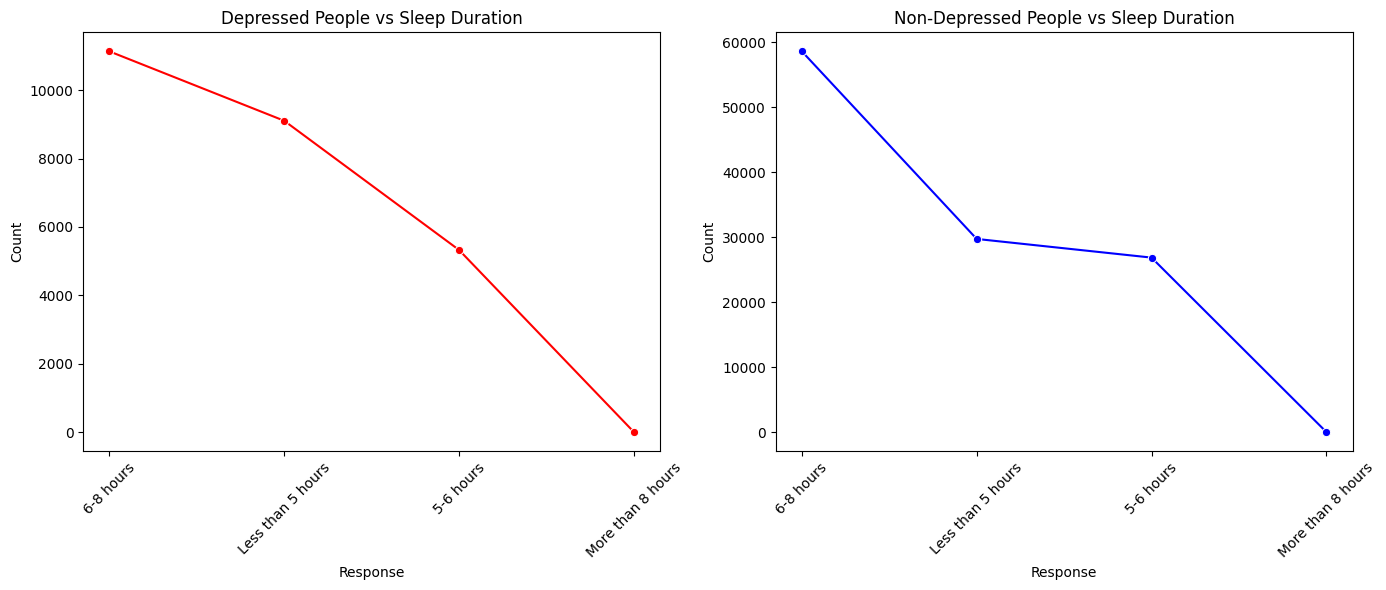

In [21]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.lineplot(
    data=depressed_sleep_cycle, 
    x='Sleep Duration', 
    y='Depression', 
    marker='o', 
    color='red', 
    ax=axes[0]
)
axes[0].set_title("Depressed People vs Sleep Duration")
axes[0].set_xlabel("Response")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(
    data=non_depressed_sleep_cycle, 
    x='Sleep Duration', 
    y='Depression', 
    marker='o', 
    color='blue', 
    ax=axes[1]
)
axes[1].set_title("Non-Depressed People vs Sleep Duration")
axes[1].set_xlabel("Response")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [22]:
def categorize_diet(habit):
    
    if pd.isna(habit):  
        return "Invalid"

    habit = str(habit).lower().strip() 

    words = habit.split() 

    if any(x in words for x in ["healthy", "more healthy"]):
        return "Healthy"
    elif "moderate" in words:
        return "Moderate"
    elif any(x in words for x in ["unhealthy", "less healthy", "less than healthy", "no healthy"]):
        return "Unhealthy"
    else:
        return "Invalid"
    
data['Dietary Habits'] = data['Dietary Habits'].apply(categorize_diet)
data.drop(data[data['Dietary Habits'] == 'Invalid'].index, inplace = True)

In [23]:
depressed_diet = data[data['Depression'] == 1].groupby('Dietary Habits')['Depression'].count().sort_values(ascending = False).reset_index()
non_depressed_diet = data[data['Depression'] == 0].groupby('Dietary Habits')['Depression'].count().sort_values(ascending = False).reset_index()

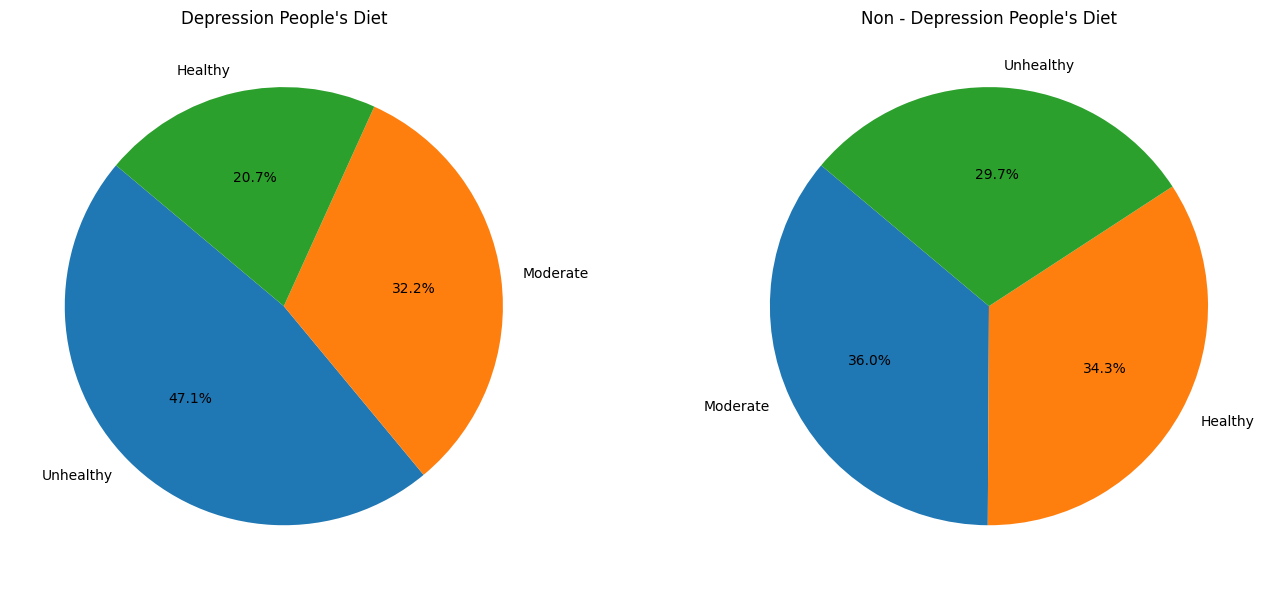

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(
    depressed_diet['Depression'],  
    labels=depressed_diet['Dietary Habits'],
    autopct='%1.1f%%',  
    startangle=140
)
axes[0].set_title("Depression People's Diet")

axes[1].pie(
    non_depressed_diet['Depression'],  
    labels=non_depressed_diet['Dietary Habits'],
    autopct='%1.1f%%',  
    startangle=140  
)
axes[1].set_title("Non - Depression People's Diet")

plt.tight_layout()
plt.show()

In [25]:
depressed_thoughts = data[data['Depression'] == 1].groupby('Have you ever had suicidal thoughts ?')['Depression'].count().sort_values(ascending = False).reset_index()
non_depressed_thoughts = data[data['Depression'] == 0].groupby('Have you ever had suicidal thoughts ?')['Depression'].count().sort_values(ascending = False).reset_index()

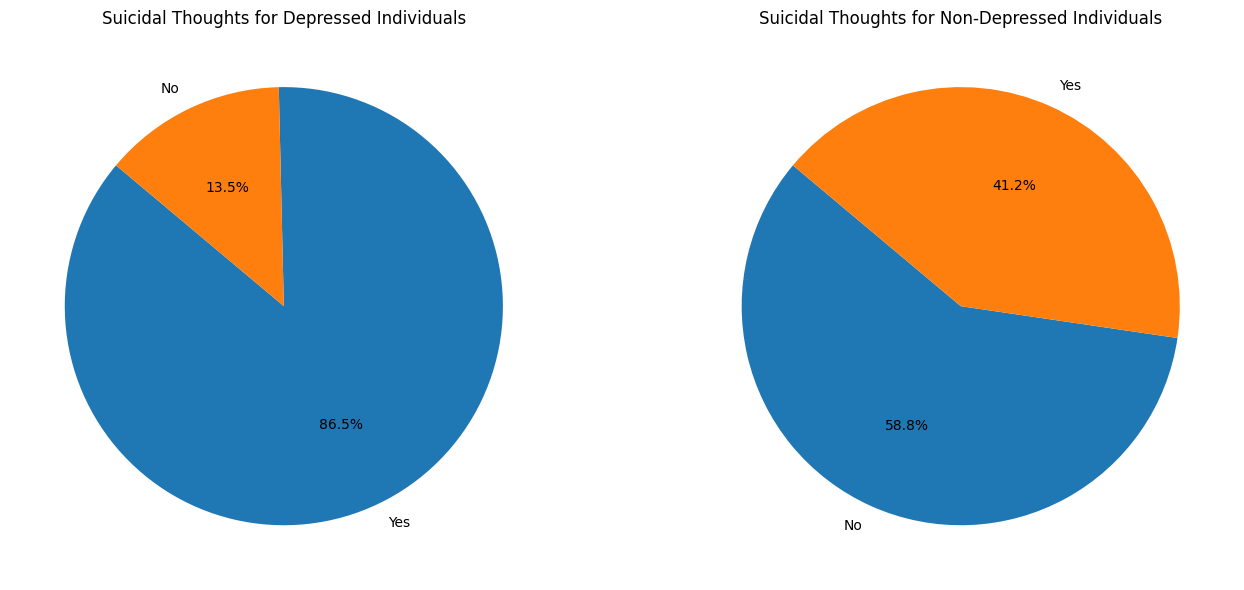

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(
    depressed_thoughts['Depression'],  
    labels=depressed_thoughts['Have you ever had suicidal thoughts ?'],
    autopct='%1.1f%%',  
    startangle=140
)
axes[0].set_title("Suicidal Thoughts for Depressed Individuals")

axes[1].pie(
    non_depressed_thoughts['Depression'],  
    labels=non_depressed_thoughts['Have you ever had suicidal thoughts ?'],
    autopct='%1.1f%%',  
    startangle=140  
)
axes[1].set_title("Suicidal Thoughts for Non-Depressed Individuals")

plt.tight_layout()
plt.show()

In [27]:
depressed_work_hr = data[data['Depression'] == 1].groupby('Work/Study Hours')['Depression'].count().sort_values(ascending = False).reset_index().head(10)
non_depressed_work_hr = data[data['Depression'] == 0].groupby('Work/Study Hours')['Depression'].count().sort_values(ascending = False).reset_index().head(10)

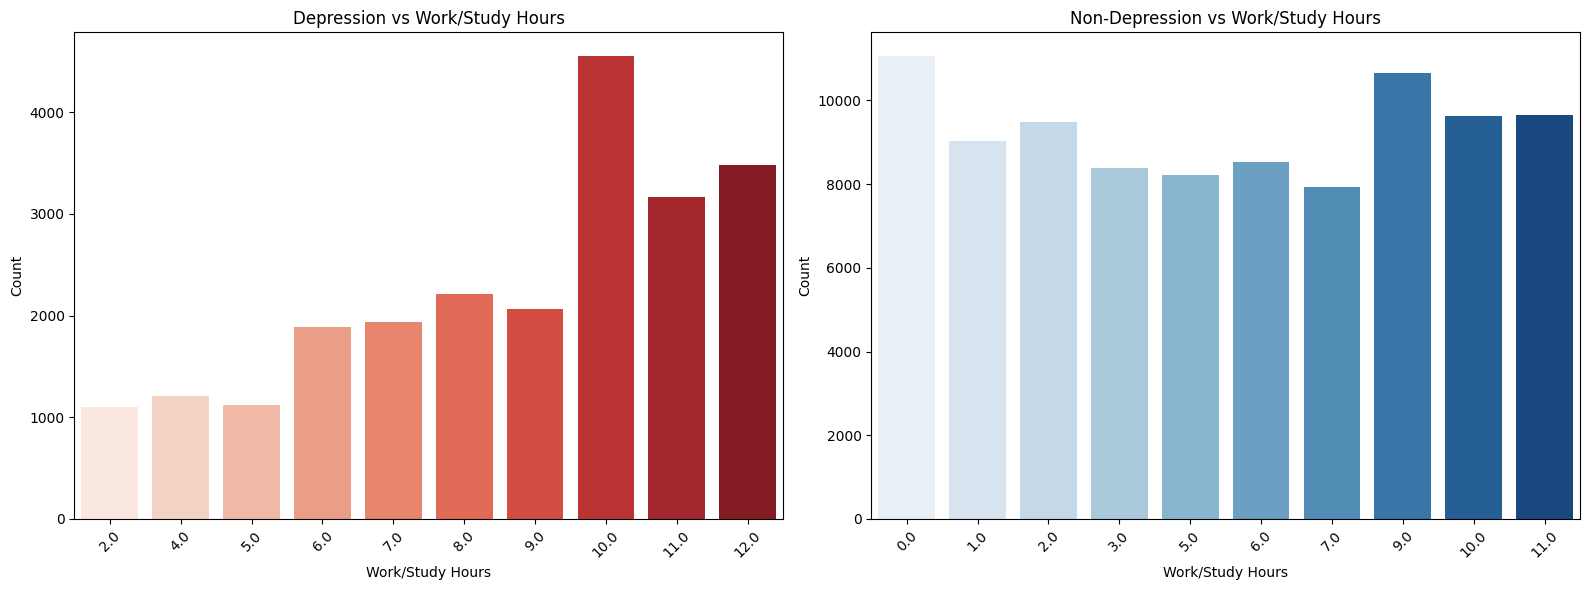

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=depressed_work_hr, x='Work/Study Hours', y='Depression', ax=axes[0], palette='Reds')
axes[0].set_title("Depression vs Work/Study Hours")
axes[0].set_xlabel("Work/Study Hours")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=non_depressed_work_hr, x='Work/Study Hours', y='Depression', ax=axes[1], palette='Blues')
axes[1].set_title("Non-Depression vs Work/Study Hours")
axes[1].set_xlabel("Work/Study Hours")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [29]:
depressed_lineage = data[data['Depression'] == 1].groupby('Family History of Mental Illness')['Depression'].count().sort_values(ascending = False).reset_index()
non_depressed_lineage = data[data['Depression'] == 0].groupby('Family History of Mental Illness')['Depression'].count().sort_values(ascending = False).reset_index()

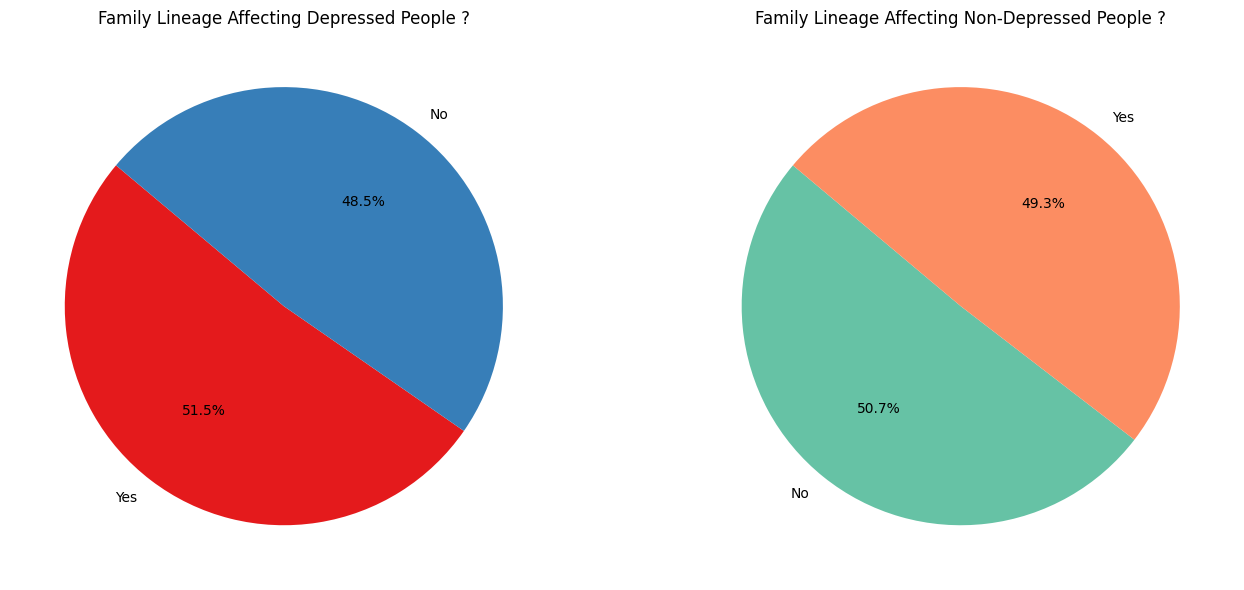

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(
    depressed_lineage['Depression'],  
    labels=depressed_lineage['Family History of Mental Illness'],
    autopct='%1.1f%%',  
    startangle=140,
    colors=plt.cm.Set1.colors
)
axes[0].set_title("Family Lineage Affecting Depressed People ?")

axes[1].pie(
    non_depressed_lineage['Depression'],  
    labels=non_depressed_lineage['Family History of Mental Illness'],
    autopct='%1.1f%%',  
    startangle=140,
    colors=plt.cm.Set2.colors  
)
axes[1].set_title("Family Lineage Affecting Non-Depressed People ?")

plt.tight_layout()
plt.show()

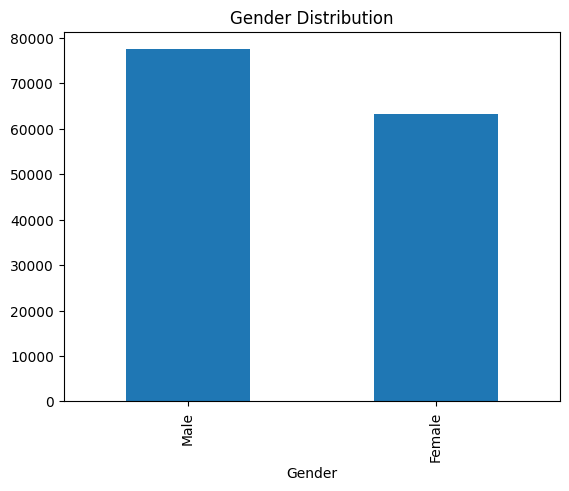

In [31]:
# Bias Fairness

data["Gender"].value_counts().plot(kind="bar", title="Gender Distribution")
plt.show()

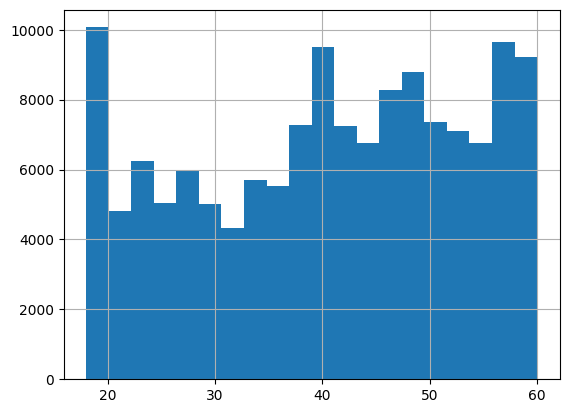

In [32]:
data["Age"].hist(bins=20)
plt.show()

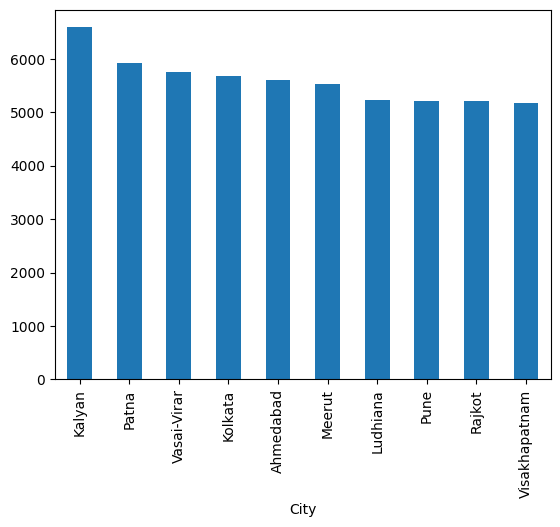

In [33]:
data["City"].value_counts().head(10).plot(kind="bar")
plt.show()